## Plan for getting back to where we started and replicating the duckdb error we were trying to solve last week
- [x] Get the code from the github issue (https://github.com/duckdb/duckdb/issues/7015)
- [x] install jupysql (update)
- [x] check if `duckdb` version is current or update it or revert to standard release instead of `dev` release
- [x] try running the code we ran into a bug with in the notebook
- [x] reproduce the error
- [x] Try following advice in the github issues comments section
- [x] Follow-up with any comments 

## Backup plan if we are still stuck on loading Zulip data
- [ ] Ask GPT-4 for help standardizing NYC 3-1-1 data
- [ ] Visualize 3-digit ZIP level map or something

In [1]:
# check duckdb version
import duckdb
duckdb.__version__

'0.7.1'

## Uninstall duckdb and reinstall the non-development (public) version

```
me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   pip uninstall duckdb                                          3584  10:03:01  
Found existing installation: duckdb 0.7.2.dev1637
Uninstalling duckdb-0.7.2.dev1637:
  Would remove:
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/duckdb-0.7.2.dev1637.dist-info/*
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/duckdb-stubs/__init__.pyi
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/duckdb.cpython-311-darwin.so
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/pyduckdb/bytes_io_wrapper.py
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/pyduckdb/filesystem.py
Proceed (Y/n)? y
  Successfully uninstalled duckdb-0.7.2.dev1637
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   pip install duckdb                                            3585  10:04:29  
Collecting duckdb
  Using cached duckdb-0.7.1-cp311-cp311-macosx_11_0_arm64.whl (12.4 MB)
Installing collected packages: duckdb
Successfully installed duckdb-0.7.1
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main       
 ```

In [2]:
# smallest possible test case for SQL query using jupyter notebook cell magic commands
import duckdb
import pandas as pd

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

# Set configrations on jupysql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connect jupysql to DuckDB using a SQLAlchemy-style connection string. Either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///:memory:

In [2]:
file_size_in_bytes = 2934074

file_size_in_megabytes = file_size_in_bytes / 1024 / 1024

thousand_times_file_size = 1000 * file_size_in_bytes

print("The file size is: " + str(file_size_in_megabytes) + " MB")

The file size is: 2.7981510162353516 MB


In [5]:
%%sql 
SELECT *
FROM read_json('./data/datathinking.zulipchat.com/raw/messages-000001.json',
               json_format='array_of_records',
               maximum_object_size=:file_size_in_bytes,
               columns={
                   'zerver_message': 'STRUCT(id BIGINT, 
                                             sender BIGINT, 
                                             recipient BIGINT, 
                                             realm BIGINT, 
                                             subject VARCHAR, 
                                             content VARCHAR, rendered_content VARCHAR, rendered_content_version BIGINT, 
                                             date_sent TIMESTAMP, sending_client BIGINT, last_edit_time TIMESTAMP, edit_history VARCHAR, has_attachment BOOLEAN, has_image BOOLEAN, 
                                             has_link BOOLEAN, search_tsvector VARCHAR)',
                    'zerver_usermessage': 'STRUCT(id BIGINT, 
                                                  user_profile BIGINT, 
                                                  message BIGINT, 
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);

StatementError: (sqlalchemy.exc.InvalidRequestError) A value is required for bind parameter 'file_size_in_bytes'
[SQL: SELECT *
FROM read_json('./data/datathinking.zulipchat.com/raw/messages-000001.json',
               json_format='array_of_records',
               maximum_object_size=?,
               columns={
                   'zerver_message': 'STRUCT(id BIGINT, 
                                             sender BIGINT, 
                                             recipient BIGINT, 
                                             realm BIGINT, 
                                             subject VARCHAR, 
                                             content VARCHAR, rendered_content VARCHAR, rendered_content_version BIGINT, 
                                             date_sent TIMESTAMP, sending_client BIGINT, last_edit_time TIMESTAMP, edit_history VARCHAR, has_attachment BOOLEAN, has_image BOOLEAN, 
                                             has_link BOOLEAN, search_tsvector VARCHAR)',
                    'zerver_usermessage': 'STRUCT(id BIGINT, 
                                                  user_profile BIGINT, 
                                                  message BIGINT, 
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);]
(Background on this error at: https://sqlalche.me/e/14/cd3x)

## VERY IMPORTANT!
* we cannot seem to re-create the bug with the same software environment we used last week!
* this means we are using a mix of old and new software versions, some in development like `duckdb`, and we need to be clear about when we are at risk of taking responsibility for the bugs versus when we are just using software that is in development and we are not responsible for the bugs
* this is hard to ascertain! writing things down a lot (on physical pencil and paper, or here), can help. 

## Could the error message have changed?

The original error message:
```python
(duckdb.InvalidInputException) Invalid Input Error: Malformed JSON in file "[./data/datathinking.zulipchat.com/raw/messages-000001.json](https://file+.vscode-resource.vscode-cdn.net/Users/me/dropbox/projects/datathinking.org-codespace-main/notebooks/in-class-notebooks/data/datathinking.zulipchat.com/raw/messages-000001.json)", at byte 2 in line 2: unexpected end of data. 
(Background on this error at: https://sqlalche.me/e/14/f405)
```

The new error message:
```python
Output exceeds the size limit. Open the full output data in a text editor---------------------------------------------------------------------------
InvalidRequestError                       Traceback (most recent call last)
File /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/sqlalchemy/engine/base.py:1800, in Connection._execute_context(self, dialect, constructor, statement, parameters, execution_options, *args, **kw)
   1798         conn = self._revalidate_connection()
-> 1800     context = constructor(
   1801         dialect, self, conn, execution_options, *args, **kw
   1802     )
   1803 except (exc.PendingRollbackError, exc.ResourceClosedError):

File /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/sqlalchemy/engine/default.py:995, in DefaultExecutionContext._init_compiled(cls, dialect, connection, dbapi_connection, execution_options, compiled, parameters, invoked_statement, extracted_parameters, cache_hit)
    993 if not parameters:
    994     self.compiled_parameters = [
--> 995         compiled.construct_params(
    996             extracted_parameters=extracted_parameters,
    997             escape_names=False,
    998         )
    999     ]
   1000 else:

File /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/sqlalchemy/sql/compiler.py:1062, in SQLCompiler.construct_params(self, params, _group_number, _check, extracted_parameters, escape_names)
   1061     else:
-> 1062         raise exc.InvalidRequestError(
   1063             "A value is required for bind parameter %r"
   1064             % bindparam.key,
   1065             code="cd3x",
...
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);]
(Background on this error at: https://sqlalche.me/e/14/cd3x)
```

I don't think the error message could have changed -- we checked that we are using `duckdb` 0.7.1. The error message can only change if we update the duckdb library to the development version (and get the latest commits from the github repo!).

## Maybe the error was caused by using a different version of `jupysql` because we just upgraded it

Let's go back to `jupysql==0.6.6`:

```bash
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   pip install jupysql --upgrade                                                                          3586  10:11:51  
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   pip uninstall jupysql                                                                      SIGINT(2) ↵  3586  10:13:36  
Found existing installation: jupysql 0.7.0
Uninstalling jupysql-0.7.0:
  Would remove:
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/jupysql-0.7.0.dist-info/*
    /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/sql/*
Proceed (Y/n)? y
  Successfully uninstalled jupysql-0.7.0
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   pip install jupysql==0.6.6                                                                             3587  10:13:41  
Collecting jupysql==0.6.6
  Using cached jupysql-0.6.6-py3-none-any.whl (30 kB)
Requirement already satisfied: prettytable in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (3.6.0)
Requirement already satisfied: ipython>=1.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (8.11.0)
Requirement already satisfied: sqlalchemy<2 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (1.4.47)
Requirement already satisfied: sqlparse in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (0.4.3)
Requirement already satisfied: ipython-genutils>=0.1.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (0.2.0)
Requirement already satisfied: jinja2 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (3.1.2)
Requirement already satisfied: ploomber-core>=0.2.4 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jupysql==0.6.6) (0.2.9)
Requirement already satisfied: backcall in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.2.0)
Requirement already satisfied: decorator in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (5.1.1)
Requirement already satisfied: jedi>=0.16 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.18.2)
Requirement already satisfied: matplotlib-inline in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.1.6)
Requirement already satisfied: pickleshare in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.7.5)
Requirement already satisfied: prompt-toolkit!=3.0.37,<3.1.0,>=3.0.30 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (3.0.38)
Requirement already satisfied: pygments>=2.4.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (2.14.0)
Requirement already satisfied: stack-data in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.6.2)
Requirement already satisfied: traitlets>=5 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (5.9.0)
Requirement already satisfied: pexpect>4.3 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (4.8.0)
Requirement already satisfied: appnope in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ipython>=1.0->jupysql==0.6.6) (0.1.3)
Requirement already satisfied: click in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ploomber-core>=0.2.4->jupysql==0.6.6) (8.1.3)
Requirement already satisfied: pyyaml in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ploomber-core>=0.2.4->jupysql==0.6.6) (6.0)
Requirement already satisfied: posthog in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from ploomber-core>=0.2.4->jupysql==0.6.6) (2.4.0)
Requirement already satisfied: MarkupSafe>=2.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jinja2->jupysql==0.6.6) (2.1.2)
Requirement already satisfied: wcwidth in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from prettytable->jupysql==0.6.6) (0.2.6)
Requirement already satisfied: parso<0.9.0,>=0.8.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from jedi>=0.16->ipython>=1.0->jupysql==0.6.6) (0.8.3)
Requirement already satisfied: ptyprocess>=0.5 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from pexpect>4.3->ipython>=1.0->jupysql==0.6.6) (0.7.0)
Requirement already satisfied: requests<3.0,>=2.7 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (2.28.2)
Requirement already satisfied: six>=1.5 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (1.16.0)
Requirement already satisfied: monotonic>=1.5 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (1.6)
Requirement already satisfied: backoff>=1.10.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (2.2.1)
Requirement already satisfied: python-dateutil>2.1 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (2.8.2)
Requirement already satisfied: executing>=1.2.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from stack-data->ipython>=1.0->jupysql==0.6.6) (1.2.0)
Requirement already satisfied: asttokens>=2.1.0 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from stack-data->ipython>=1.0->jupysql==0.6.6) (2.2.1)
Requirement already satisfied: pure-eval in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from stack-data->ipython>=1.0->jupysql==0.6.6) (0.2.2)
Requirement already satisfied: charset-normalizer<4,>=2 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from requests<3.0,>=2.7->posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (2.0.4)
Requirement already satisfied: idna<4,>=2.5 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from requests<3.0,>=2.7->posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (3.4)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from requests<3.0,>=2.7->posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (1.26.15)
Requirement already satisfied: certifi>=2017.4.17 in /opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages (from requests<3.0,>=2.7->posthog->ploomber-core>=0.2.4->jupysql==0.6.6) (2022.12.7)
Installing collected packages: jupysql
Successfully installed jupysql-0.6.6
```

## Let's see if the jupysql version caused the error message being different and hard to reproduce

In [6]:
%%sql 
SELECT *
FROM read_json('./data/datathinking.zulipchat.com/raw/messages-000001.json',
               json_format='array_of_records',
               maximum_object_size=:file_size_in_bytes,
               columns={
                   'zerver_message': 'STRUCT(id BIGINT, 
                                             sender BIGINT, 
                                             recipient BIGINT, 
                                             realm BIGINT, 
                                             subject VARCHAR, 
                                             content VARCHAR, rendered_content VARCHAR, rendered_content_version BIGINT, 
                                             date_sent TIMESTAMP, sending_client BIGINT, last_edit_time TIMESTAMP, edit_history VARCHAR, has_attachment BOOLEAN, has_image BOOLEAN, 
                                             has_link BOOLEAN, search_tsvector VARCHAR)',
                    'zerver_usermessage': 'STRUCT(id BIGINT, 
                                                  user_profile BIGINT, 
                                                  message BIGINT, 
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);

StatementError: (sqlalchemy.exc.InvalidRequestError) A value is required for bind parameter 'file_size_in_bytes'
[SQL: SELECT *
FROM read_json('./data/datathinking.zulipchat.com/raw/messages-000001.json',
               json_format='array_of_records',
               maximum_object_size=?,
               columns={
                   'zerver_message': 'STRUCT(id BIGINT, 
                                             sender BIGINT, 
                                             recipient BIGINT, 
                                             realm BIGINT, 
                                             subject VARCHAR, 
                                             content VARCHAR, rendered_content VARCHAR, rendered_content_version BIGINT, 
                                             date_sent TIMESTAMP, sending_client BIGINT, last_edit_time TIMESTAMP, edit_history VARCHAR, has_attachment BOOLEAN, has_image BOOLEAN, 
                                             has_link BOOLEAN, search_tsvector VARCHAR)',
                    'zerver_usermessage': 'STRUCT(id BIGINT, 
                                                  user_profile BIGINT, 
                                                  message BIGINT, 
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);]
(Background on this error at: https://sqlalche.me/e/14/cd3x)

## Not sure what version of jupysql is running in memory, need to restart kernel to make sure that version `0.6.6` of jupysql is running

In [3]:
%%sql 
SELECT *
FROM read_json('./data/datathinking.zulipchat.com/raw/messages-000001.json',
               json_format='array_of_records',
               maximum_object_size=:file_size_in_bytes,
               columns={
                   'zerver_message': 'STRUCT(id BIGINT, 
                                             sender BIGINT, 
                                             recipient BIGINT, 
                                             realm BIGINT, 
                                             subject VARCHAR, 
                                             content VARCHAR, rendered_content VARCHAR, rendered_content_version BIGINT, 
                                             date_sent TIMESTAMP, sending_client BIGINT, last_edit_time TIMESTAMP, edit_history VARCHAR, has_attachment BOOLEAN, has_image BOOLEAN, 
                                             has_link BOOLEAN, search_tsvector VARCHAR)',
                    'zerver_usermessage': 'STRUCT(id BIGINT, 
                                                  user_profile BIGINT, 
                                                  message BIGINT, 
                                                  flags_mask BIGINT)'
                        },
               lines='true'
);

(duckdb.InvalidInputException) Invalid Input Error: Malformed JSON in file "./data/datathinking.zulipchat.com/raw/messages-000001.json", at byte 2 in line 2: unexpected end of data. 
(Background on this error at: https://sqlalche.me/e/14/f405)


/opt/homebrew/anaconda3/envs/datathinking.org/lib/python3.11/site-packages/sql/command.py:109: FutureWarning: Variable substitution with $var and {var} has been deprecated and will be removed in a future version. Use {{var}} instead. To remove this, see: https://jupysql.ploomber.io/en/latest/howto.html#ignore-deprecation-warnings
  warnings.warn(msg, FutureWarning)


## Amazing! We completed the checklist item to reproduce the error we had last week that we were trying to get back to!

* it took a while
* i was trying to do too much -- this kind of "shotgun debugging" approach is not the best way to debug
* instead, slowing down, being careful can help us. 

## Save progress to reproduce error

```bash
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   conda env export > environment.yml     SIGINT(2) ↵  3588  10:17:18  
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main    git add environment.yml                  3589  10:17:26  
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main    git commit -m 'revert jupysql and duckdb versions to reproduce error in read_json'
[main c3f6369] revert jupysql and duckdb versions to reproduce error in read_json
 1 file changed, 3 insertions(+), 2 deletions(-)
 me@laptop   ~/dropbox/projects/datathinking.org-codespace-main     main   1  gp                                                          3591  10:18:50  
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 10 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 543 bytes | 543.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/onefact/datathinking.org-codespace.git
   9b18bee..c3f6369  main -> main
```

## Does it make sense why this commit is important? 

What could have happened if we didn't do this?

https://github.com/onefact/datathinking.org-codespace/commit/c3f6369c0c31c50c7844bc18c4c21b0754296046

A commit message is a way to call attention to something, another cognitive aid, to help yourself and others understand what we are doing and why. It's a way of sharing information with ourselves at a later date.



## Now we can actually try to follow the advice in the comments that are trying to help us load the Zulip data!

In [7]:
%%sql
SELECT * FROM read_json_auto('./data/datathinking.zulipchat.com/raw/messages-000001.json', maximum_object_size=99999999);

,zerver_message,zerver_usermessage
0,"[{'id': 299488052, 'sender': 100007, 'recipien...","[{'id': 8257034355, 'user_profile': 544719, 'm..."


In [8]:
df = _

In [10]:
df.describe()

,zerver_message,zerver_usermessage
count,1,1
unique,1,1
top,"[{'id': 299488052, 'sender': 100007, 'recipien...","[{'id': 8257034355, 'user_profile': 544719, 'm..."
freq,1,1


In [12]:
df.loc[0].zerver_message

[{'id': 299488052,
  'sender': 100007,
  'recipient': 924073,
  'realm': 47304,
  'subject': 'topic demonstration',
  'content': 'This is a message on stream #**general** with the topic `topic demonstration`.',
  'rendered_content': '<p>This is a message on stream <a class="stream" data-stream-id="345278" href="/#narrow/stream/345278-general">#general</a> with the topic <code>topic demonstration</code>.</p>',
  'rendered_content_version': 1,
  'date_sent': 1663549367.691131,
  'sending_client': 1002,
  'last_edit_time': None,
  'edit_history': None,
  'has_attachment': False,
  'has_image': False,
  'has_link': True,
  'search_tsvector': "'demonstrate':2,14 'demonstration':2,14 'general':9 'message':6 'stream':8 'topic':1,12,13"},
 {'id': 299488053,
  'sender': 100007,
  'recipient': 924073,
  'realm': 47304,
  'subject': 'topic demonstration',
  'content': 'Topics are a lightweight tool to keep conversations organized. You can learn more about topics at [Streams and topics](/help/stre

## This person seems nice and like they are trying to be helpful, but maybe we have not been clear about our intent 

- [x] seems like they may not have understood our intent so we commented again to clarify: https://github.com/duckdb/duckdb/issues/7015
- [x] filed issue on Zulip: https://github.com/zulip/zulip/issues/25152 

In [13]:
%%sql
CREATE TABLE service_requests AS SELECT *
FROM read_csv('/Users/me/Downloads/311_Service_Requests_from_2010_to_Present.csv',
    HEADER=True,
    DELIM=',',
    QUOTE='"',
    COLUMNS={'Unique Key': 'BIGINT', 'Created Date': 'VARCHAR', 'Closed Date': 'VARCHAR', 'Agency': 'VARCHAR', 'Agency Name': 'VARCHAR', 'Complaint Type': 'VARCHAR', 'Descriptor': 'VARCHAR', 'Location Type': 'VARCHAR', 'Incident Zip': 'VARCHAR', 'Incident Address': 'VARCHAR', 'Street Name': 'VARCHAR', 'Cross Street 1': 'VARCHAR', 'Cross Street 2': 'VARCHAR', 'Intersection Street 1': 'VARCHAR', 'Intersection Street 2': 'VARCHAR', 'Address Type': 'VARCHAR', 'City': 'VARCHAR', 'Landmark': 'VARCHAR', 'Facility Type': 'VARCHAR', 'Status': 'VARCHAR', 'Due Date': 'VARCHAR', 'Resolution Description': 'VARCHAR', 'Resolution Action Updated Date': 'VARCHAR', 'Community Board': 'VARCHAR', 'BBL': 'VARCHAR', 'Borough': 'VARCHAR', 'X Coordinate (State Plane)': 'VARCHAR', 'Y Coordinate (State Plane)': 'VARCHAR', 'Open Data Channel Type': 'VARCHAR', 'Park Facility Name': 'VARCHAR', 'Park Borough': 'VARCHAR', 'Vehicle Type': 'VARCHAR', 'Taxi Company Borough': 'VARCHAR', 'Taxi Pick Up Location': 'VARCHAR', 'Bridge Highway Name': 'VARCHAR', 'Bridge Highway Direction': 'VARCHAR', 'Road Ramp': 'VARCHAR', 'Bridge Highway Segment': 'VARCHAR', 'Latitude': 'DOUBLE', 'Longitude': 'DOUBLE', 'Location': 'VARCHAR'});


: 

: 

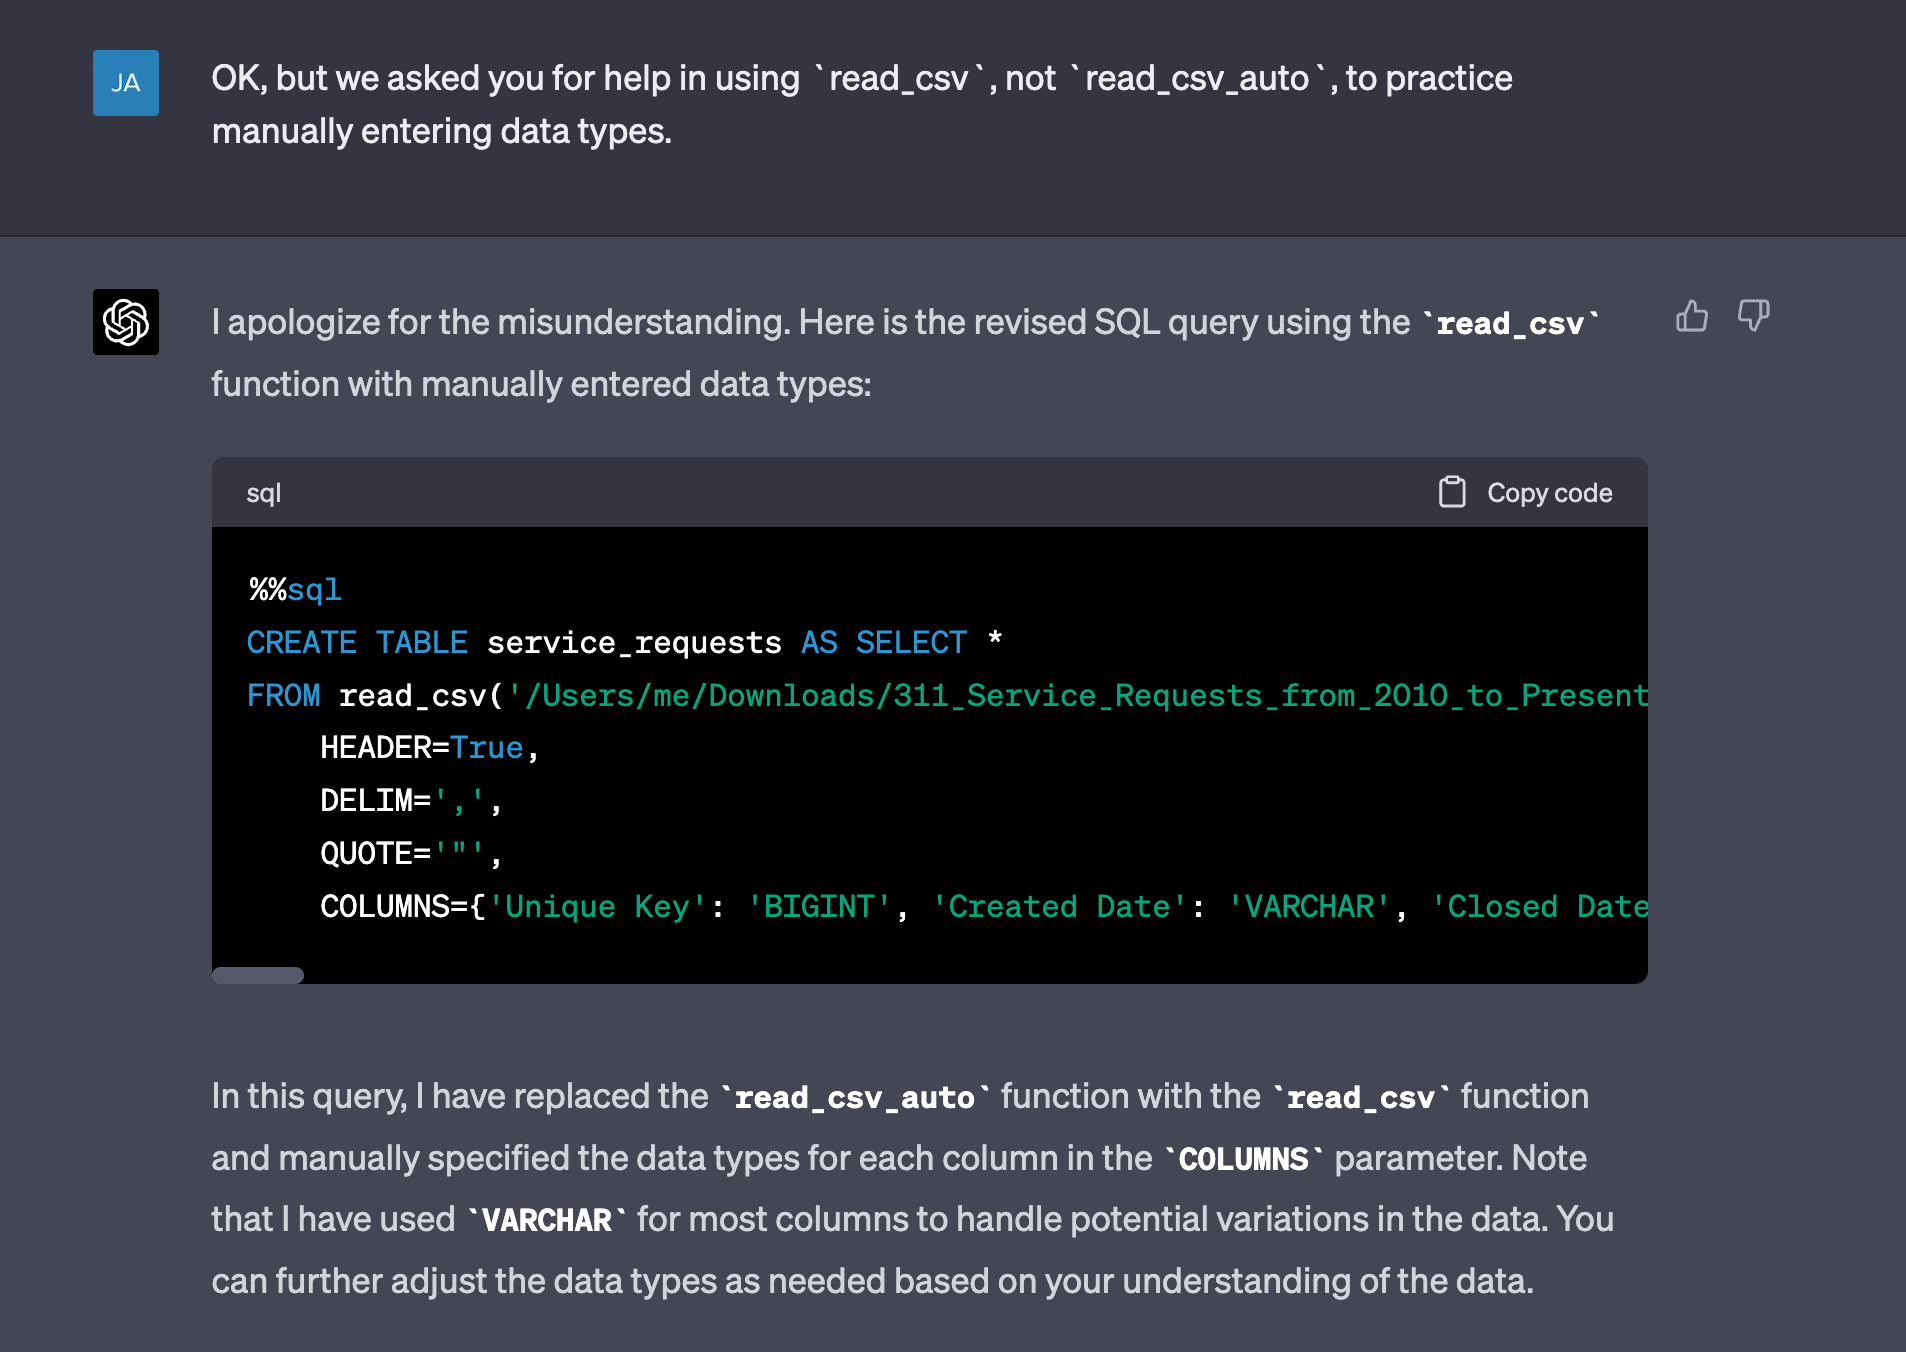

Notes on experience:
* looks like GPT-4 didn't read the documentation correctly :(
* We had to read about STRUCT data types (https://duckdb.org/docs/sql/data_types/struct) and read about CSV loading in duckdb (https://duckdb.org/docs/data/csv/overview.html) and then try to edit it. 

In [3]:
%%sql
SELECT *
FROM read_csv('/Users/me/Downloads/311_Service_Requests_from_2010_to_Present.csv',
    header=True,
    delim=',',
    quote='"',
    columns={'Unique Key': 'BIGINT', 'Created Date': 'VARCHAR', 'Closed Date': 'VARCHAR', 'Agency': 'VARCHAR', 'Agency Name': 'VARCHAR', 'Complaint Type': 'VARCHAR', 'Descriptor': 'VARCHAR', 'Location Type': 'VARCHAR', 'Incident Zip': 'VARCHAR', 'Incident Address': 'VARCHAR', 'Street Name': 'VARCHAR', 'Cross Street 1': 'VARCHAR', 'Cross Street 2': 'VARCHAR', 'Intersection Street 1': 'VARCHAR', 'Intersection Street 2': 'VARCHAR', 'Address Type': 'VARCHAR', 'City': 'VARCHAR', 'Landmark': 'VARCHAR', 'Facility Type': 'VARCHAR', 'Status': 'VARCHAR', 'Due Date': 'VARCHAR', 'Resolution Description': 'VARCHAR', 'Resolution Action Updated Date': 'VARCHAR', 'Community Board': 'VARCHAR', 'BBL': 'VARCHAR', 'Borough': 'VARCHAR', 'X Coordinate (State Plane)': 'VARCHAR', 'Y Coordinate (State Plane)': 'VARCHAR', 'Open Data Channel Type': 'VARCHAR', 'Park Facility Name': 'VARCHAR', 'Park Borough': 'VARCHAR', 'Vehicle Type': 'VARCHAR', 'Taxi Company Borough': 'VARCHAR', 'Taxi Pick Up Location': 'VARCHAR', 'Bridge Highway Name': 'VARCHAR', 'Bridge Highway Direction': 'VARCHAR', 'Road Ramp': 'VARCHAR', 'Bridge Highway Segment': 'VARCHAR', 'Latitude': 'DOUBLE', 'Longitude': 'DOUBLE', 'Location': 'VARCHAR'});


## Nota bene: this command would have crashed the notebook or my computer! NEed to edit to limit output

to fix, let's try limiting output to 10 rows.

In [7]:
%%sql
SELECT *
FROM read_csv('/Users/me/Downloads/311_Service_Requests_from_2010_to_Present.csv',
    header=True,
    delim=',',
    quote='"',
    columns={'Unique Key': 'BIGINT', 'Created Date': 'VARCHAR', 'Closed Date': 'VARCHAR', 'Agency': 'VARCHAR', 'Agency Name': 'VARCHAR', 'Complaint Type': 'VARCHAR', 'Descriptor': 'VARCHAR', 'Location Type': 'VARCHAR', 'Incident Zip': 'VARCHAR', 'Incident Address': 'VARCHAR', 'Street Name': 'VARCHAR', 'Cross Street 1': 'VARCHAR', 'Cross Street 2': 'VARCHAR', 'Intersection Street 1': 'VARCHAR', 'Intersection Street 2': 'VARCHAR', 'Address Type': 'VARCHAR', 'City': 'VARCHAR', 'Landmark': 'VARCHAR', 'Facility Type': 'VARCHAR', 'Status': 'VARCHAR', 'Due Date': 'VARCHAR', 'Resolution Description': 'VARCHAR', 'Resolution Action Updated Date': 'VARCHAR', 'Community Board': 'VARCHAR', 'BBL': 'VARCHAR', 'Borough': 'VARCHAR', 'X Coordinate (State Plane)': 'VARCHAR', 'Y Coordinate (State Plane)': 'VARCHAR', 'Open Data Channel Type': 'VARCHAR', 'Park Facility Name': 'VARCHAR', 'Park Borough': 'VARCHAR', 'Vehicle Type': 'VARCHAR', 'Taxi Company Borough': 'VARCHAR', 'Taxi Pick Up Location': 'VARCHAR', 'Bridge Highway Name': 'VARCHAR', 'Bridge Highway Direction': 'VARCHAR', 'Road Ramp': 'VARCHAR', 'Bridge Highway Segment': 'VARCHAR', 'Latitude': 'DOUBLE', 'Longitude': 'DOUBLE', 'Location': 'VARCHAR'}) 
LIMIT 1000000;

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,34247134,09/04/2016 02:35:29 PM,09/07/2016 03:50:31 PM,DPR,Department of Parks and Recreation,Maintenance or Facility,Hours of Operation,Beach,11235,None,...,None,None,None,None,None,None,None,NaN,NaN,None
1,34250114,09/05/2016 03:47:42 PM,09/07/2016 03:47:11 PM,DOF,Land Records,DOF Property - Update Account,Billing Name Incorrect,Property Address,11224,None,...,None,None,None,None,None,None,None,NaN,NaN,None
2,34249970,09/05/2016 03:56:00 PM,09/12/2016 10:06:25 AM,DPR,Department of Parks and Recreation,Maintenance or Facility,Structure - Indoors,Park,10027,None,...,None,None,None,None,None,None,None,NaN,NaN,None
3,27050693,01/04/2014 02:10:00 PM,01/20/2014 09:50:00 AM,DOT,Department of Transportation,Traffic Signal Condition,LED Lense,None,None,None,...,None,None,None,None,None,None,None,NaN,NaN,None
4,34262636,09/07/2016 09:49:51 AM,09/15/2016 07:00:28 PM,DOF,Refunds and Adjustments,DOF Property - Payment Issue,Property Refunds and Credits,Property Address,10014,None,...,None,None,None,None,None,None,None,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,16901519,06/19/2010 05:27:00 PM,06/19/2010 07:35:00 PM,DEP,Department of Environmental Protection,Sewer,Manhole Cover Missing (Emergency) (SA3),None,10022,306 EAST 59 STREET,...,None,None,None,None,None,None,None,40.760411,-73.963888,"(40.76041100049983, -73.96388833030763)"
999996,16901520,06/19/2010 05:23:00 PM,06/20/2010 03:55:00 AM,DEP,Department of Environmental Protection,Water System,Hydrant Running Full (WA4),None,10451,710 CONCOURSE VILLAGE WEST,...,None,None,None,None,None,None,None,40.821950,-73.924043,"(40.82195046118972, -73.92404260527317)"
999997,16901521,06/19/2010 05:08:00 PM,06/19/2010 05:09:00 PM,DEP,Department of Environmental Protection,Water System,Hydrant Running (WC3),None,11367,61-52 149 STREET,...,None,None,None,None,None,None,None,40.739645,-73.820537,"(40.739644564631654, -73.82053708356474)"
999998,16901522,06/19/2010 05:31:00 PM,07/14/2010 12:33:00 PM,DEP,Department of Environmental Protection,Air Quality,"Air: Odor/Fumes, Restaurant (AD2)",None,10036,596 10 AVENUE,...,None,None,None,None,None,None,None,40.760392,-73.994903,"(40.76039184487642, -73.99490307261837)"


ProgrammingError: (duckdb.CatalogException) Catalog Error: Table with name no-outliers does not exist!
Did you mean "temp.information_schema.tables"?
LINE 5: FROM "no-outliers"
             ^
[SQL: 
SELECT
    MIN("'Incident Zip'"),
    MAX("'Incident Zip'")
FROM "no-outliers"]
(Background on this error at: https://sqlalche.me/e/14/f405)

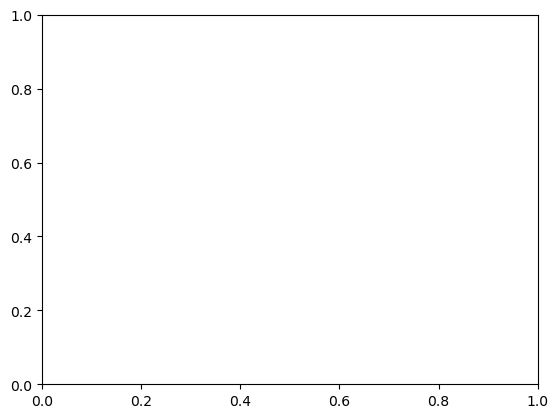

In [10]:
%sqlplot histogram --table no-outliers --column 'Incident Zip'

## Nota been: we haven't called the table anything, let's call it `service_requests`

In [3]:
%%sql
CREATE TABLE service_requests 
AS SELECT *
FROM read_csv('/Users/me/Downloads/311_Service_Requests_from_2010_to_Present.csv',
    header=True,
    delim=',',
    quote='"',
    columns={'Unique Key': 'BIGINT', 'Created Date': 'VARCHAR', 'Closed Date': 'VARCHAR', 'Agency': 'VARCHAR', 'Agency Name': 'VARCHAR', 'Complaint Type': 'VARCHAR', 'Descriptor': 'VARCHAR', 'Location Type': 'VARCHAR', 'Incident Zip': 'VARCHAR', 'Incident Address': 'VARCHAR', 'Street Name': 'VARCHAR', 'Cross Street 1': 'VARCHAR', 'Cross Street 2': 'VARCHAR', 'Intersection Street 1': 'VARCHAR', 'Intersection Street 2': 'VARCHAR', 'Address Type': 'VARCHAR', 'City': 'VARCHAR', 'Landmark': 'VARCHAR', 'Facility Type': 'VARCHAR', 'Status': 'VARCHAR', 'Due Date': 'VARCHAR', 'Resolution Description': 'VARCHAR', 'Resolution Action Updated Date': 'VARCHAR', 'Community Board': 'VARCHAR', 'BBL': 'VARCHAR', 'Borough': 'VARCHAR', 'X Coordinate (State Plane)': 'VARCHAR', 'Y Coordinate (State Plane)': 'VARCHAR', 'Open Data Channel Type': 'VARCHAR', 'Park Facility Name': 'VARCHAR', 'Park Borough': 'VARCHAR', 'Vehicle Type': 'VARCHAR', 'Taxi Company Borough': 'VARCHAR', 'Taxi Pick Up Location': 'VARCHAR', 'Bridge Highway Name': 'VARCHAR', 'Bridge Highway Direction': 'VARCHAR', 'Road Ramp': 'VARCHAR', 'Bridge Highway Segment': 'VARCHAR', 'Latitude': 'DOUBLE', 'Longitude': 'DOUBLE', 'Location': 'VARCHAR'}) 
LIMIT 100000;

,Count
0,100000


In [6]:
%%sql
SELECT column_name
FROM pragma_table_info('service_requests');


(duckdb.BinderException) Binder Error: Referenced column "column_name" not found in FROM clause!
Candidate bindings: "pragma_table_info.name"
LINE 1: SELECT column_name
               ^
[SQL: SELECT column_name
FROM pragma_table_info('service_requests');]
(Background on this error at: https://sqlalche.me/e/14/f405)


ProgrammingError: (duckdb.BinderException) Binder Error: Referenced column "'Incident Zip'" not found in FROM clause!
Candidate bindings: "service_requests.Incident Zip"
LINE 3:     MIN("'Incident Zip'"),
                ^
[SQL: 
SELECT
    MIN("'Incident Zip'"),
    MAX("'Incident Zip'")
FROM "service_requests"]
(Background on this error at: https://sqlalche.me/e/14/f405)

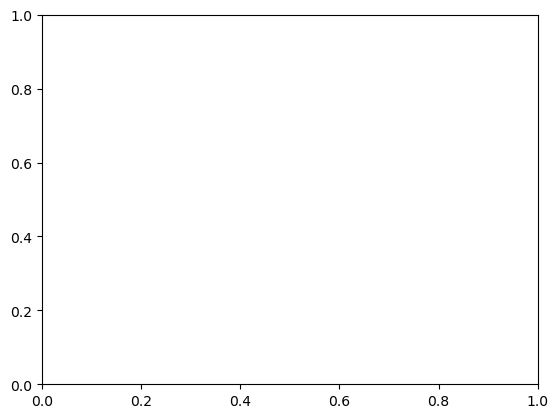

In [5]:
%sqlplot histogram --table service_requests --column 'Incident Zip'

Can't seem to understand column names or table names, docs to read for homework:

https://duckdb.org/docs/guides/meta/list_tables.html

https://duckdb.org/docs/sql/statements/select.html

In [7]:
%%sql
DESCRIBE service_requests

,column_name,column_type,null,key,default,extra
0,Unique Key,BIGINT,YES,None,None,None
1,Created Date,VARCHAR,YES,None,None,None
2,Closed Date,VARCHAR,YES,None,None,None
3,Agency,VARCHAR,YES,None,None,None
4,Agency Name,VARCHAR,YES,None,None,None
5,Complaint Type,VARCHAR,YES,None,None,None
6,Descriptor,VARCHAR,YES,None,None,None
7,Location Type,VARCHAR,YES,None,None,None
8,Incident Zip,VARCHAR,YES,None,None,None
9,Incident Address,VARCHAR,YES,None,None,None


ProgrammingError: (duckdb.BinderException) Binder Error: Referenced column "'latitude'" not found in FROM clause!
Candidate bindings: "service_requests.Latitude"
LINE 3:     MIN("'latitude'"),
                ^
[SQL: 
SELECT
    MIN("'latitude'"),
    MAX("'latitude'")
FROM "service_requests"]
(Background on this error at: https://sqlalche.me/e/14/f405)

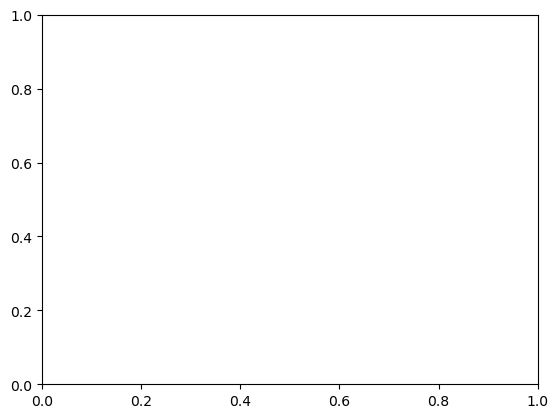

In [8]:
%sqlplot histogram --table service_requests --column 'latitude'

<Axes: title={'center': "'latitude' from 'service_requests'"}, ylabel='latitude'>

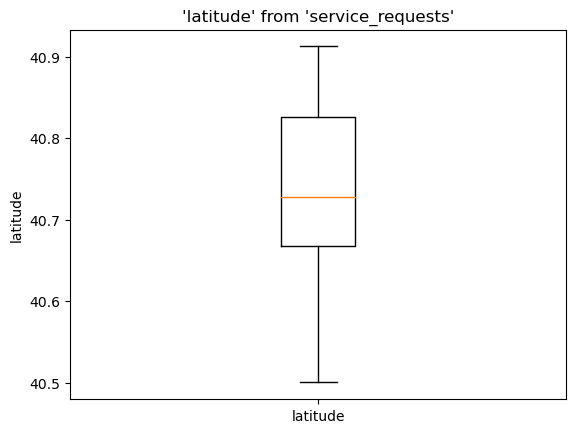

In [9]:
%sqlplot boxplot --table service_requests --column latitude


<Axes: title={'center': "'longitude' from 'service_requests'"}, ylabel='longitude'>

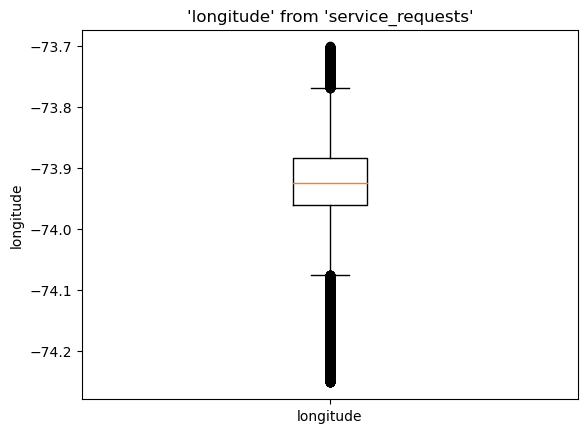

In [10]:
%sqlplot boxplot --table service_requests --column longitude
